# Problem 2 : Partitionning the Bus Fleet

In part 1, you were able to solve the simple MaxCut problem. Let's spice things up a bit by taking more information into account!

## Problem Statement
> The STS wishes to add 5 buses each serving a different line, to accomodate the growing need felt by users for the morning departures of 08:00 am and 08:30. Given that some bus lines intersect, we want to organize the buses into 2 groups. Ideally, we want the buses serving the same stops to depart at different times as much as possible.

### Supplementary Information
In this problem, all bus line intertsections are not equal.
An **intersecting weight** is specified, corresponding to the number of common edges between two bus lines. This translates the fact that some bus lines have more stops in common than other and thus, partionning them into different groups takes priority.

The following table summarizes the intersection weights for each bus line (i.e. the number of edges in common between each pair of bus lines):

<p align="center">
<img src="figures/table_prob2_ENG.png" alt="prob2" width="500"/>
</p>

**A larger weight** means that two bus lines shares a higher number of edges.

## Goal
Your goal is to **minimize the sum of intersection weights** in each departure group. In other words, you want to divide the departure lines sharing many stops.

### How : You need to
- encode the problem into a `SparsePauliOp` Hamiltonian
- optimize the parameters of your QAOA circuit
- select a good set of hyperparameters (number of layers, optimizer, ...)

#### Evaluation : You must
- Show a mentor that you were able to run your code correctly (showing cell outputs is sufficient)
- Show the optimal solutions you identified for this problem

In [4]:
# Visualization of the problem graph
import matplotlib.pyplot as plt
import networkx as nx

# Matricial computation and calssical optimization
import numpy as np
from scipy.optimize import minimize

# Creation of quantum circuits
from qiskit import QuantumCircuit

# Structure used to build Hamiltonians
from qiskit.quantum_info import SparsePauliOp

# Method used to create QAOA circuits to optimize
from qiskit.circuit.library import QAOAAnsatz

# Tools used for the execution of quantum circuits
from qiskit_ibm_runtime import QiskitRuntimeService
from qiskit_ibm_runtime import EstimatorV2 as Estimator
from qiskit_ibm_runtime import SamplerV2 as Sampler

# Transpilation of quantum circuits on IBM's simulators and quantum computers
from qiskit.transpiler.preset_passmanagers import generate_preset_pass_manager

# Quantum computer simulator
from qiskit_aer import AerSimulator

# Simulators of existing quantum computers
from qiskit_ibm_runtime.fake_provider import FakeNairobiV2  # , FakeQuebec

# Visualization of probablity distributions
from qiskit.visualization import plot_histogram

backend = AerSimulator()  # Can be changed for different simulators or a real quantum backend, if desired
estimator = Estimator(mode=backend)

# Define a transpilation tool needed by Qiskit to run the simulation.
pm = generate_preset_pass_manager(backend=backend, optimization_level=1)

# Define the classical cost function to optimize
def cost_function(
    params: list[complex], estimator: Estimator, circuit: QuantumCircuit, hamiltonian: SparsePauliOp
) -> float:
    """
    Cost function that computes the average value of an observable ('hamiltonian') for a given state ('circuit').
    This average value represents the cost function described by the input Hamiltonian. Also, the
    parametrized circuit and its parameters are defined in the 'params' vector.
    Everything is evaluated by the estimator.

    Args:
        params (list[complex]): List of parameters to be inserted in 'circuit'.
        estimator (Estimator): Estimates the desired average values.
        circuit (QuantumCircuit): QAOA's parametrized circuit.
        hamiltonian (SparsePauliOp): Observable associated to the problem's cost function

    Returns:
        float: Cost associated to the input parameters.
    """
    isa_psi = pm.run(circuit)
    isa_observables = hamiltonian.apply_layout(isa_psi.layout)

    job = estimator.run([(isa_psi, isa_observables, params)])
    cost = job.result()[0].data.evs
    return cost
simulator = AerSimulator()
sampler = Sampler(simulator)
estimator = Estimator(simulator)

In [5]:
# Instanciate your Hamiltonian
H = SparsePauliOp.from_list(
    [("IIIZZ", 10), ("IIZZI", 11), ("IZZII", 8), ("IZIIZ", 11), ("ZIIIZ", 13), ("ZIIZI", 10)]
)

In [ ]:
# Instanciate your QAOA circuit
nb_layers = 12  # Modifier comme il vous plait

# Instantiate the QAOA circuit with Qiskit's implementation
circuit_qaoa = QAOAAnsatz(H, reps=nb_layers)

# Display the QAOA circuit if you want :-)
#circuit_qaoa.decompose(reps=1).draw(output="mpl", style="iqp")

In [26]:
# Hyperparameter optimisation
#TODO
params_init = np.linspace(0.01,1.5,circuit_qaoa.num_parameters)

# Classical optimization of QAOA circuit using Scipy
#TODO
res_opt = minimize(
    cost_function, params_init, args=(estimator, circuit_qaoa, H), method="COBYLA"
)  # , options={"tol": 1e-14}

# Information extraction following optimization
cost_opt = res_opt.fun  # Optimal cost evaluated
params_opt = res_opt.x  # Optimal parameters evaluated

# Displaying the results 
print("Optimal cost found :", cost_opt)
print("Optimal parameters found :", params_opt)

Optimal cost found : -31.185546875
Optimal parameters found : [ 1.01360354 -0.00754481  0.12707413  0.14373759  0.22426817  1.05253734
  0.10117987  0.36639698  0.41590615  0.4381834   0.48264893  0.57490152
  0.63194132  0.71223569  1.60385055  0.78795988  0.83294656  0.88609457
  0.9351142   0.98475973  1.04249805  1.11047541  1.1398094   1.18372413
  1.22780703  1.28794068  1.34770143  1.41036617  1.44305957  1.51387845]


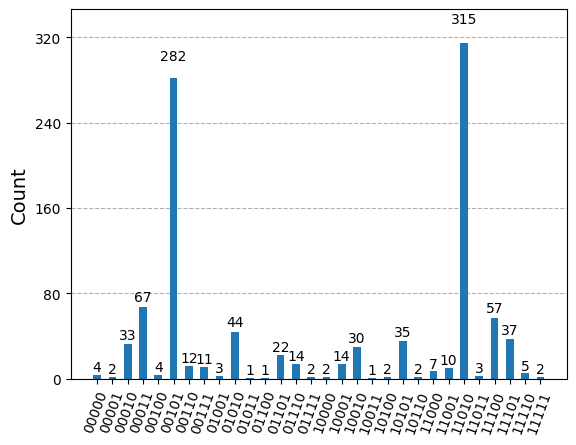

In [27]:
# Result analysis and identified solutions
# Instanciate a Sampler to obtain a probability distribution
sampler = Sampler(mode=backend)

# Compute the probability distribution with the optimal parameters that you found previously
circuit_qaoa_copy = circuit_qaoa.decompose(reps=2).copy()
circuit_qaoa_copy.measure_all()
circuit_qaoa_copy.draw()
counts = sampler.run([(circuit_qaoa_copy, params_opt)]).result()[0].data.meas.get_counts()
# Display the probability distribution
plot_histogram(counts)

In [28]:
answers=[]
for key,value in counts.items():
    if value>70:
        answers.append(key)

print(answers)

['00101', '11010']


In [29]:
from problemes_utils import compute_exact_sol

print(compute_exact_sol(H))

(-43.0, ['00101', '11010'])


In [30]:
from problemes_utils import calc_score

calc_score(params_opt,nb_layers,H,backend)

Optimal cost :  -31.15625
Score :  59.9609375


(array(-31.15625), 59.9609375)